## Exercise 6.9

In [3]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pylab
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

First a simple data loading function.

In [4]:
# load data
def load_data(filename):
    data = np.array(np.genfromtxt(filename, delimiter=','))  
    x = data[:,:-1]# np.reshape(data[:,0:1],(np.size(data[:,0:1]),1))
    y = np.reshape(data[:,-1],(np.size(data[:,-1]),1))
    return x,y

Now we need a function to transform input features into Fourier features.

In [5]:
def poly_features(x,D):
    """generates polynomial features with orders ranging from 0->D"""
    x.shape = (x.size,1)
    order = np.tile(np.arange(0,D+1), (x.size,1))
    F = np.power( np.tile(x, (1,D+1)), order) # []   
    return F.T



def poly_features_multiDim(x,D):
    """generates polynomial features with orders ranging from 0->D"""   
    #return x[:,0:D+1].T   
   # F = np.zeros((D+1, x.shape[0]))  
   # F[0,:] = np.ones((1,x.shape[0])) 
   # F[1:,:] = x[:,0:D].T  
   # print(D)

    #return F
    poly = PolynomialFeatures(D)
    F = poly.fit_transform(x)  
    return F.T

def fourier_features(x,D):
    """takes fourier coefficients"""
    x.shape = (x.size,1)
    F = np.zeros((2*D+1, x.size))    
    F[0,:] = np.ones((1,x.size))      
    for i in np.arange(1,D+1):        
        F[2*i-1,:] = np.cos(2*np.pi*x*i).flatten()
        F[2*i,:] = np.sin(2*np.pi*x*i).flatten()         
    return F

def softmax_grad(F,y,w,nIter):
    alpha = 10**-2#10**-2    
    for k in range(nIter): 
        r = np.zeros((F.shape[1],1))
        for p in range(y.shape[0]):
            r = r + -1 * sigmoid(-y[p] * (F.T @ w)) * y[p]
        grad = F @ r     
        w = w - alpha * grad
    return w

def sigmoid(t):
    return 1/(1 + np.exp(-t))


In [6]:
# plot the polynomial  

def plot_model_2D(w,D,y,ax,plot_color):
    # plot determined surface in 3d space
    s = np.arange(0, 1, .025)#.025)
    ns = s.size
    
    s.shape = (ns,1)
    sx, sy = np.meshgrid(s,s)
    sx2 = sx.flatten()
    sx2.shape = (sx2.size,1)
    sy2 = sy.flatten()
    sy2.shape = (sy2.size,1)
    s = np.concatenate((sx2,sy2),axis=1)   

    f = poly_features_multiDim(s,D)
    z = np.dot(f.T,w)
    z = np.reshape(z,sx.shape)
 
    ax.contour(sx, sy, z, levels=[0])
    plt.axis([-.05,1.05,-.05,1.05])
    #plt.axis([-.1,2,-1,2])
    return ax

def plot_mse(ax, mses, deg, plot_color, legStr, titStr,xStr):
    plt.sca(ax)
    #plt.plot(np.arange(1,np.size(mses)+1),mses,'--', color = plot_color, label=legStr)
    plt.plot(deg,mses,'--^', color = plot_color, label=legStr)
    plt.title(titStr, fontsize=18)
    plt.xlabel(xStr, fontsize=18)
    plt.ylabel('error')
    plt.xlabel('degree D')
            
# plot data 
def plot_data_1D(x,y,i,plot_color, grid):
    plt.subplot(grid[int(np.floor(i/3)), (i % 3) ])
    plt.scatter(x,y,s = 30, color = plot_color)
    plt.axis([-.1,1.1,-.1,1.1])
    s = 'Hold out #' + str(i)
    plt.title(s, fontsize=15)

# plot data 
def plot_data(x,i,plot_color, grid,sT=30, alphaT =1):
    plt.subplot(grid[int(np.floor(i/3)), (i % 3) ])
    plt.scatter(x[:,0],x[:,1],s = sT, color = plot_color, alpha=alphaT)
    plt.axis([-.1,1.1,-.1,1.1])
    s = 'Hold out #' + str(i)
    plt.title(s, fontsize=15)    
    
# plot data 
def plot_data_final(x,plot_color, grid):        
    plt.subplot(grid[0,3])
    plt.scatter(x[:,0],x[:,1],s = 30, color = plot_color)        
        
def partition_indices(length, n):
    indices = np.arange(length)
    np.random.shuffle(indices)
    q, r = divmod(length, n)
    stIndices = [q*i + min(i, r) for i in range(n+1)]
    return [indices[stIndices[i]:stIndices[i+1]] for i in range(n)]  

def partition_indices_better(x, y, k):
    kf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    return [test_index for test_index, test_index in kf.split(x, y)]  
        

In [7]:
# run over all the degrees, fit each models, and calculate errors
def hold_out_validation(x, y, k, deg_range):  
    nIter = 100
    nP = x.shape[0]
    is_in = y == 1
    is_out = np.logical_not(is_in)
    
    #indices = partition_indices(nP, k)
    
    indices = partition_indices_better(x,y,k)
    
    grid = plt.GridSpec(2, 4, wspace=0.15, hspace=0.3)
    color_test = 'orange'    
    color_train = 'blue'
    fig = plt.figure(figsize = (24,10))
        
    mses_test = np.zeros((k,deg_range.size))
    mses_train = np.zeros((k,deg_range.size))
    
 
    for i in np.arange(0,3):#k): 
        
        is_test = np.zeros(nP, dtype=bool)
        is_test[indices[i]] = True
        is_train = np.logical_not(is_test)  

        yTrain = y[is_train]
        yTest  = y[is_test]
        
        for D in np.arange(0,np.size(deg_range)):
            # First we find the optimal number of features for this training set  
            
            F_train = poly_features_multiDim(x[is_train,:], deg_range[D])                
            F_test  = poly_features_multiDim(x[is_test,:], deg_range[D])   
            

            temp = np.linalg.pinv(np.dot(F_train, F_train.T))             
            w = np.dot(np.dot(temp, F_train),yTrain) 

            trainMSEtemp = np.sign(-yTrain * np.dot(F_train.T, w))
            trainMSEtemp[trainMSEtemp < 0] = 0
            
            testMSEtemp = np.sign(-yTest * np.dot(F_test.T, w))
            testMSEtemp[testMSEtemp < 0] = 0
           
            mses_train[i,D] = np.sum(trainMSEtemp)/trainMSEtemp.shape[0]
            mses_test[i,D] = np.sum(testMSEtemp)/testMSEtemp.shape[0]
         
        # choose best case number of features and plot the final model
        deg_final = deg_range[np.argmin(mses_test[i,:])]   
        F_train = poly_features_multiDim(x[is_train,:], deg_final)   
        temp = np.linalg.pinv(np.dot(F_train, F_train.T))             
        w = np.dot(np.dot(temp, F_train), yTrain)      

        if(i<=3):
            plot_data(x[np.logical_and(np.squeeze(is_out),is_train),:], i, 'g', grid, 30, 1)        
            plot_data(x[np.logical_and(np.squeeze(is_out),is_test),:], i, 'g', grid, 30, .15)
            plot_data(x[np.logical_and(np.squeeze(is_in),is_train),:], i, 'r', grid, 30, 1)
            plot_data(x[np.logical_and(np.squeeze(is_in),is_test),:], i, 'r', grid, 30, .15)
            s = 'Hold out #%d/%d: M = %d' % (i+1,k,deg_final)
            plt.title(s, fontsize=15)

            ax = plt.subplot(grid[int(np.floor(i/k)), (i % 3) ])
           # plot_model_2D(w,deg_final,y,ax,'k')
            ax =  plt.subplot(grid[int(np.floor(i/k))+ 1, (i % 3)  ])
            plot_mse(ax, mses_test[i,:], deg_range, color_test, '', '','')
            plot_mse(ax, mses_train[i,:], deg_range, color_train, '', '','')

    mse_train = numpy.mean(mses_train, axis=0)
    mse_test = numpy.mean(mses_test, axis=0)
    plot_mse(plt.subplot(grid[1,3]), mse_test, deg_range, color_test, 'Testing Error','','')
    plot_mse(plt.subplot(grid[1,3]), mse_train, deg_range, color_train, 'Training Error', 'Average MSE','degree D')
    plt.legend()
    
  
    # get and plot weights for FINAL model         
    deg_final = deg_range[np.argmin(mse_test)]       
    F = poly_features_multiDim(x, deg_final) 
                             
    temp = np.linalg.pinv(np.dot(F,F.T))             
    w = np.dot(np.dot(temp,F),y) 

    ax =  plt.subplot(grid[0,3])
    
    plot_data_final(x[np.squeeze(is_out),:], 'g', grid)
    plot_data_final(x[np.squeeze(is_in),:], 'r', grid)

   # plot_model_2D(w, deg_final, y, ax, 'r')
    plt.title('Average Model: D = %i' % deg_final, fontsize=14)
    plt.show()    

x:  (16384, 3)


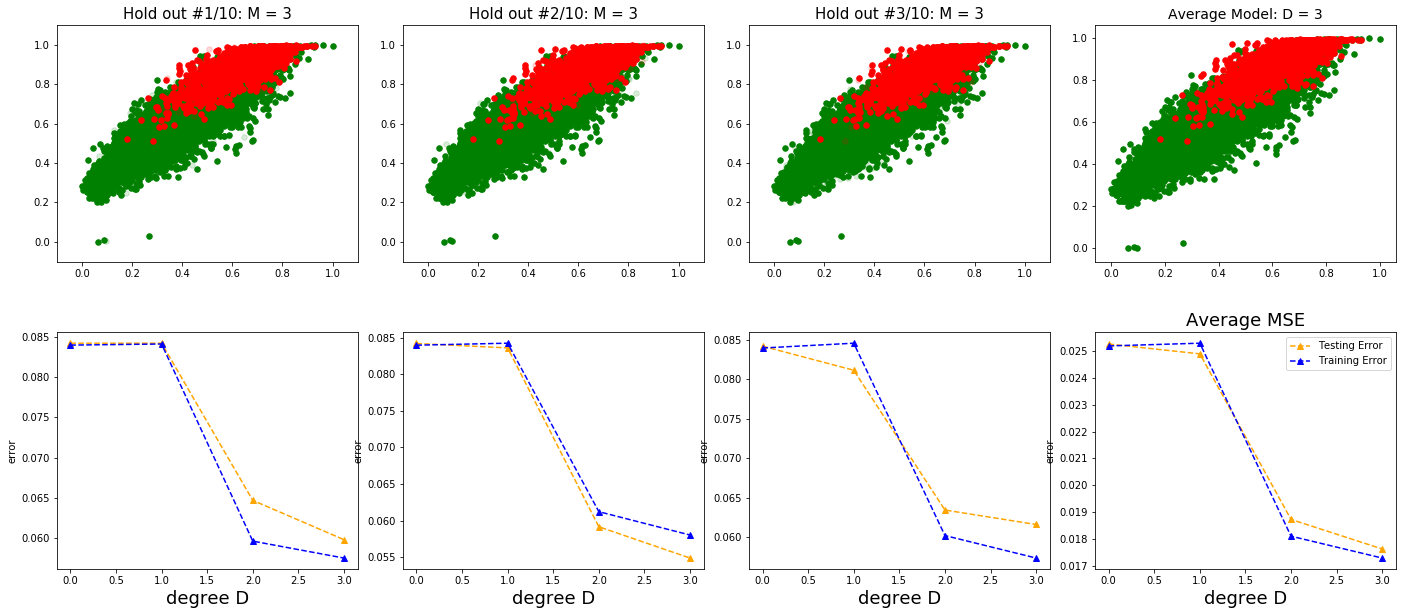

In [8]:
# load data and defined degree range  
#x, y = load_data('2eggs_data.csv')
#x, y = load_data('DATA_W2_downsampled_pt2.csv')
#x, y = load_data('DATA_W1_downsampled_pt2.csv')
#x, y = load_data('data_dn2\DATA_W1_downsampled.csv')
x, y = load_data('data_dn4_3d\DATA_W1_downsampled.csv')

print('x: ', x.shape)
#for i in range(2,2):#5):#11):
#    xT, yT = load_data('data_dn4_3d\DATA_W' + str(i) + '_downsampled.csv')
#    x = np.concatenate((x,xT),axis=0);
#    y =  np.concatenate((y,yT),axis=0)

# switch x1 and x2 for visibility
#xT = np.copy(x)
#x[:,1] = xT[:,0]
#x[:,0] = xT[:,1]


for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - np.min(x[:,i]))/np.ptp(x[:,i])


y[y==0] = -1; 

# hold out validation
k = 10

# degrees to test
deg_range = np.arange(0,4)#10)#np.arange(0,12)

hold_out_validation(x,y,k,deg_range)